In [59]:
#Install/import necessary packages
!pip install mtgsdk
from mtgsdk import Card
from bs4 import BeautifulSoup

from pandas.api.types import CategoricalDtype
from scipy.stats.mstats import gmean
import seaborn as sns
import requests
import pandas as pd
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from pandas.api.types import CategoricalDtype

# CARD DATA 

The following sections involve gathering and processing a new dataset. To load the pre-processed data (if it exists) see the cell just before the Price Scraping section.

If you don't have the data/modernCardsUnprocessed.pickle file, run these cells:

In [64]:
#Get all modern cards
cards = Card.where(gameFormat='modern').all()
cardDicts = [c.__dict__ for c in cards]
cardsDf = pd.DataFrame(cardDicts)

In [65]:
if cardsDf is not None:
    with open('data/modernCardsUnprocessed.pickle','wb') as pickle_out:
        pickle.dump(cardsDf,pickle_out)

Otherwise, run these cell:

In [67]:
#Open unprocessed data
with open('data/modernCardsUnprocessed.pickle','rb') as pickle_in:
    cardsDf = pickle.load(pickle_in)

In [68]:
#Filter out the lands
types = cardsDf['types']

nonlandFilter = ["Land" not in t for t in types]

nonLands = pd.DataFrame(cardsDf.loc[nonlandFilter])

In [69]:
#This will fix list columns with null values and join lists by commas
def fixListCol(el):
    if el == None:
        return ''
    elif type(el) == list:
        return ','.join(el)
    return el

In [70]:
def separateMana(col):
    if col is None:
        return {}
    return {color:1 for color in col}

In [71]:
colors = pd.DataFrame(list(nonLands['color_identity'].apply(separateMana))).fillna(0)
colors = colors.set_index(nonLands.index)

In [64]:
print(colors.loc[8443])

B    0.0
G    1.0
R    0.0
U    0.0
W    0.0
Name: 8443, dtype: float64


In [72]:
nonLandsColorsSeparate = nonLands.merge(colors,left_index=True,right_index=True)

In [73]:
# Apply the fix to relevant columns
nonLandsColorsSeparate['supertypes'] = nonLandsColorsSeparate['supertypes'].apply(fixListCol)
nonLandsColorsSeparate['types'] = nonLandsColorsSeparate['types'].apply(fixListCol)
nonLandsColorsSeparate['subtypes'] = nonLandsColorsSeparate['subtypes'].apply(fixListCol)


In [74]:
#Select the relevant columns
cardsDfFinal = nonLandsColorsSeparate[['artist','cmc','color_identity','layout','loyalty','mana_cost','name','power','rarity','subtypes','supertypes','text','timeshifted','toughness','types','set','W','U','B','R','G']]

print(cardsDfFinal.head())

            artist  cmc color_identity  layout  loyalty  mana_cost  \
0      Warren Mahy    4            [R]  normal      NaN     {3}{R}   
16  Douglas Shuler    5            [W]  normal      NaN  {3}{W}{W}   
17  Trevor Claxton    4            [G]  normal      NaN  {2}{G}{G}   
18            Izzy    3         [W, U]  normal      NaN  {1}{W}{U}   
19    Steve Argyle    2            [W]  normal      NaN     {1}{W}   

                           name power   rarity       subtypes ...   \
0             Steamflogger Boss     3     Rare  Goblin,Rigger ...    
16                  Serra Angel     4  Special          Angel ...    
17                    Vengevine     4  Special      Elemental ...    
18         Geist of Saint Traft     2  Special  Spirit,Cleric ...    
19  Thalia, Guardian of Thraben     2  Special  Human,Soldier ...    

                                                 text timeshifted toughness  \
0   Other Riggers you control get +1/+0 and have h...        None         3   


In [75]:
cardsDfFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20018 entries, 0 to 23042
Data columns (total 21 columns):
artist            20018 non-null object
cmc               20018 non-null int64
color_identity    18135 non-null object
layout            20018 non-null object
loyalty           168 non-null float64
mana_cost         19913 non-null object
name              20018 non-null object
power             10978 non-null object
rarity            20018 non-null object
subtypes          20018 non-null object
supertypes        20018 non-null object
text              19556 non-null object
timeshifted       236 non-null object
toughness         10978 non-null object
types             20018 non-null object
set               20018 non-null object
W                 20018 non-null float64
U                 20018 non-null float64
B                 20018 non-null float64
R                 20018 non-null float64
G                 20018 non-null float64
dtypes: float64(6), int64(1), object(14)
memory us

In [76]:
#Save the data
with open('data/modernCardsFinal.pickle','wb') as pickle_out:
    pickle.dump(cardsDfFinal,pickle_out)

To load the pre-processed data:

In [3]:
with open('data/modernCardsFinal.pickle','rb') as pickle_in:
    cardsDfFinal = pickle.load(pickle_in)

# PRICE SCRAPING

If the file already exists in the data directory:

In [77]:
with open('data/modernPrices.pickle','rb') as pickle_in:
    pricesDF = pickle.load(pickle_in)

If the data needs to be scraped:

In [90]:
#This will scrape the prices from the formats included in the given format parameter (i.e. 'Modern' will scrape both Standard and Modern)
def scrapeSelectPage(url,formt):
    #Get the page
    r = requests.get(url)
    html_doc = r.text
    soup = BeautifulSoup(html_doc,'lxml')
    
    #Get the format blocks from the page
    formats = soup.find_all('div',class_='priceList-setMenu')
    pricesDF = pd.DataFrame()
    for form in formats:
        pricesDF = pricesDF.append(scrapeFormat(form))
        
        #Check if we've reached the desired format
        if 'priceList-setMenu-'+formt in form.attrs['class']:
            break
        
    return pricesDF

#Scrapes a format div from the /prices/select page
def scrapeFormat(soup):
    #Select the first li element in the format's div
    element = soup.li
    
    #Skip the first "Quick Prices" block
    element = element.find_next_sibling('li',class_='priceList-setMenu-header')
    
    #Create empty dataframe to append to
    formatDF = pd.DataFrame()
    
    #Append the Dataframes obtained by scraping each set
    while(element.find_next_sibling('li') != None):
        #Iterate
        element = element.find_next_sibling('li')
        
        #The set elements don't have classes associated with them
        if 'class' not in element.attrs:
            #Scrape the cards in the set's page and add the name of the set
            setDF = scrapeSet('https://www.mtggoldfish.com'+element.a.attrs['href']+'#paper')
            setDF['setname'] = element.get_text().strip()
            
            formatDF = formatDF.append(setDF)
            
    return formatDF

#Scrapes all of the prices from the given set page
def scrapeSet(url):
    #Get the page
    r = requests.get(url)
    html_doc = r.text
    soup = BeautifulSoup(html_doc,'lxml')
    
    #Select the cards table
    element = soup.find('table',class_='tablesorter-bootstrap-popover-paper').tbody
    
    #Build a list that will be filled with dictionaries to be converted to a DataFrame
    cardList = []
    
    #Loop through rows and scrape the name and price
    for row in element.find_all('tr'):
        #Get the td elements
        row = row.find_all('td')
        
        cardList.append({'name':row[0].a.get_text().strip(),'price':row[3].get_text().strip(),'set':row[1].get_text()})
    
    return pd.DataFrame(cardList)

In [91]:
pricesDF = scrapeSelectPage('https://www.mtggoldfish.com/prices/select','Modern')

In [8]:
with open('data/modernPrices.pickle','wb') as pickle_out:
    pickle.dump(pricesDF,pickle_out)

Look at the DF:

In [92]:
print(pricesDF.head())
pricesDF.info()
print(pricesDF.loc[pricesDF['name']=='Steamflogger Boss'])

                       name  price  set           setname
0        Rekindling Phoenix  23.27  RIX  Rivals of Ixalan
1  Kumena, Tyrant of Orazca  19.92  RIX  Rivals of Ixalan
2          Jadelight Ranger  10.99  RIX  Rivals of Ixalan
3  Angrath, Minotaur Pirate  10.25  RIX  Rivals of Ixalan
4   Vraska, Scheming Gorgon   9.97  RIX  Rivals of Ixalan
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13864 entries, 0 to 285
Data columns (total 4 columns):
name       13864 non-null object
price      13864 non-null object
set        13864 non-null object
setname    13864 non-null object
dtypes: object(4)
memory usage: 541.6+ KB
                 name price  set       setname
36  Steamflogger Boss  2.00  FUT  Future Sight


# MELD

In [4]:
#Load the existing merged dataset
with open('data/modernPricesWithData.pickle','rb') as pickle_in:
    cardsWithPrices = pickle.load(pickle_in)

In [95]:
#Merge the card info and card prices dataframes
cardsWithPrices = pricesDF.merge(cardsDfFinal,on=['name','set'])

#Set the index to the name and set
cardsWithPrices = cardsWithPrices.set_index(['set','name']).sort_index()

In [97]:
cardsWithPrices.head()

price       setname               artist  cmc  \
set name                                                                
10E Abundance            2.24  10th Edition         Rebecca Guay    4   
    Academy Researchers  0.26  10th Edition      Stephen Daniele    3   
    Afflict              0.16  10th Edition          Roger Raupp    3   
    Aggressive Urge      0.17  10th Edition  Christopher Moeller    2   
    Agonizing Memories   0.21  10th Edition             Adam Rex    4   

                        color_identity  layout  loyalty  mana_cost power  \
set name                                                                   
10E Abundance                      [G]  normal      NaN  {2}{G}{G}  None   
    Academy Researchers            [U]  normal      NaN  {1}{U}{U}     2   
    Afflict                        [B]  normal      NaN     {2}{B}  None   
    Aggressive Urge                [G]  normal      NaN     {1}{G}  None   
    Agonizing Memories             [B]  normal      NaN  {2}{B}{B}  None   

                           rarity ...  supertypes  \
set name                          ...               
10E Abundance                Rare ...               
    Academy Researchers  Uncommon ...               
    Afflict                Common ...               
    Aggressive Urge        Common ...               
    Agonizing Memories   Uncommon ...               

                                                                      text  \
set name                                                                     
10E Abundance            If you would draw a card, you may instead choo...   
    Academy Researchers  When Academy Researchers enters the battlefiel...   
    Afflict              Target creature gets -1/-1 until end of turn.\...   
    Aggressive Urge      Target creature gets +1/+1 until end of turn.\...   
    Agonizing Memories   Look at target player's hand and choose two ca...   

                        timeshifted toughness        types    W    U    B  \
set name                                                                    
10E Abundance                  None      None  Enchantment  0.0  0.0  0.0   
    Academy Researchers        None         2     Creature  0.0  1.0  0.0   
    Afflict                    None      None      Instant  0.0  0.0  1.0   
    Aggressive Urge            None      None      Instant  0.0  0.0  0.0   
    Agonizing Memories         None      None      Sorcery  0.0  0.0  1.0   

                           R    G  
set name                           
10E Abundance            0.0  1.0  
    Academy Researchers  0.0  0.0  
    Afflict              0.0  0.0  
    Aggressive Urge      0.0  1.0  
    Agonizing Memories   0.0  0.0  

[5 rows x 21 columns]

In [98]:
#Convert to useful datatypes
cardsWithPrices['cmc'] = pd.to_numeric(cardsWithPrices['cmc'])
cardsWithPrices['loyalty'] = pd.to_numeric(cardsWithPrices['loyalty'])
cardsWithPrices['price'] = pd.to_numeric(cardsWithPrices['price'])
cardsWithPrices['rarity'] = cardsWithPrices['rarity'].astype('category')
cardsWithPrices['layout'] = cardsWithPrices['layout'].astype('category')

In [102]:
#Manually adding a manacost to Suspend and no-cost Splice cards as their ability's respective cost
cardsWithPrices.loc[(slice(None),'Evermind'),'mana_cost'] = '{1}{U}'
cardsWithPrices.loc[(slice(None),'Evermind'),'cmc'] = 2

cardsWithPrices.loc[(slice(None),'Wheel of Fate'),'mana_cost'] = '{1}{R}'
cardsWithPrices.loc[(slice(None),'Wheel of Fate'),'cmc'] = 2

cardsWithPrices.loc[(slice(None),'Restore Balance'),'mana_cost'] = '{W}'
cardsWithPrices.loc[(slice(None),'Restore Balance'),'cmc'] = 1

cardsWithPrices.loc[(slice(None),'Living End'),'mana_cost'] = '{2}{B}{B}'
cardsWithPrices.loc[(slice(None),'Living End'),'cmc'] = 4

cardsWithPrices.loc[(slice(None),'Ancestral Vision'),'mana_cost'] = '{U}'
cardsWithPrices.loc[(slice(None),'Ancestral Vision'),'cmc'] = 1

cardsWithPrices.loc[(slice(None),'Lotus Bloom'),'mana_cost'] = '{0}'
cardsWithPrices.loc[(slice(None),'Lotus Bloom'),'cmc'] = 0

In [103]:
#Fill empty text 
cardsWithPrices['text'] = cardsWithPrices['text'].fillna('')

In [3]:
#Everything is good to go!
cardsWithPrices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12746 entries, (10E, Abundance) to (ZEN, Zendikar Farguide)
Data columns (total 21 columns):
price             12746 non-null float64
setname           12746 non-null object
artist            12746 non-null object
cmc               12746 non-null int64
color_identity    11557 non-null object
layout            12746 non-null category
loyalty           113 non-null float64
mana_cost         12746 non-null object
power             7062 non-null object
rarity            12746 non-null category
subtypes          12746 non-null object
supertypes        12746 non-null object
text              12746 non-null object
timeshifted       233 non-null object
toughness         7062 non-null object
types             12746 non-null object
W                 12746 non-null float64
U                 12746 non-null float64
B                 12746 non-null float64
R                 12746 non-null float64
G                 12746 non-null float64
dtypes: categ

In [105]:
with open('data/modernPricesWithData.pickle','wb') as pickle_out:
    pickle.dump(cardsWithPrices,pickle_out)

# PLAYING WITH THE DATA

I know that the VAST majority of cards are essentially worthless (only worth a couple of cents), so let's see exactly how skewed the prices are.

In [3]:
#Group the entire data set by price, let's get a count of each price
priceCounts = cardsWithPrices['price'].value_counts().sort_index(ascending = True)

print('25 cents or less: ',np.sum(priceCounts.head(19)))
print('15 cents or less: ',np.sum(priceCounts.head(9)))
print('\nCounts of the first 25 cents of prices:')
print(priceCounts.head(19))

25 cents or less:  8022
15 cents or less:  4015

Counts of the first 25 cents of prices:
0.00       1
0.05       2
0.07       1
0.10      20
0.11      52
0.12      98
0.13     212
0.14    1423
0.15    2206
0.16     357
0.17     212
0.18     240
0.19     419
0.20    1089
0.21     554
0.22     392
0.23     320
0.24     222
0.25     202
Name: price, dtype: int64


Just about 2/3 of the cards are only a quarter or less, and around 1/3 of all cards are only 15 cents.

# Value of colors

Let's see if the average card value and the variance of these values differs greatly based on color identity:

In [13]:
#Abstraction that returns a boolean mask to extracting a specific color group in a dataframe
def colorMask(df,pattern):
    return [pattern in cost for cost in df['mana_cost']]

In [54]:
#Grouping by name so that reprints don't skew the price averages
uniques = cardsWithPrices.groupby('name').agg({'price':'min','W':'first','U':'first','B':'first','R':'first','G':'first','types':'first','cmc':'first','power':'first','toughness':'first'})

In [56]:
colorPrices = pd.Series()
colorPrices['White'] = np.average(uniques.loc[uniques['W'] == 1,'price'])
colorPrices['Blue'] = np.average(uniques.loc[uniques['U'] == 1, 'price'])
colorPrices['Black'] = np.average(uniques.loc[uniques['B'] == 1, 'price'])
colorPrices['Red'] = np.average(uniques.loc[uniques['R'] == 1, 'price'])
colorPrices['Green'] = np.average(uniques.loc[uniques['G'] == 1, 'price'])

#Create a condition to find colorless
colorlessFilter = uniques['W'] + uniques['U'] + uniques['B'] + uniques['R'] + uniques['G'] == 0
colorPrices['Colorless'] = np.average(uniques.loc[colorlessFilter,'price'])

In [63]:
#MTG Color Palette
mtgPalette = sns.color_palette([sns.xkcd_rgb['beige'],sns.xkcd_rgb['azure'],sns.xkcd_rgb['black'],sns.xkcd_rgb['bright red'],sns.xkcd_rgb['greenish'],sns.xkcd_rgb['grey']])

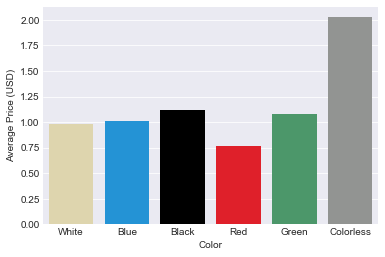

In [52]:
barplot = sns.barplot(x=colorPrices.index.values,y=colorPrices.values,palette=mtgPalette)
plt.xlabel('Color')
plt.ylabel('Average Price (USD)')
plt.show()

It looks like Red cards are generally cheaper in the modern format, whereas Colorless cards are by far the most expensive, almost doubling each other color. Now, what about the variance?

In [76]:
colorPricesVariance = pd.Series()
colorPricesVariance['White'] = np.var(uniques.loc[uniques['W'] == 1,'price'])
colorPricesVariance['Blue'] = np.var(uniques.loc[uniques['U'] == 1, 'price'])
colorPricesVariance['Black'] = np.var(uniques.loc[uniques['B'] == 1, 'price'])
colorPricesVariance['Red'] = np.var(uniques.loc[uniques['R'] == 1, 'price'])
colorPricesVariance['Green'] = np.var(uniques.loc[uniques['G'] == 1, 'price'])
colorPricesVariance['Colorless'] = np.var(uniques.loc[colorlessFilter,'price'])

C:\Users\Tyler\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


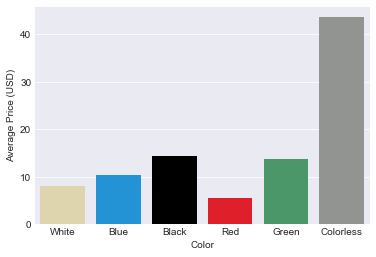

In [77]:
barplot = sns.barplot(x=colorPricesVariance.index.values,y=colorPricesVariance.values,palette=mtgPalette)
plt.xlabel('Color')
plt.ylabel('Price variance')
plt.show()

Looks like the variance of these colors are comparatively very similar to the averages, but the price of colorless cards tend to vary a bit more.

The majority of colorless cards are of the type "Artifact". Let's see the typical pricing for each card type to confirm whether or not artifacts have a higher price than others.

C:\Users\Tyler\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


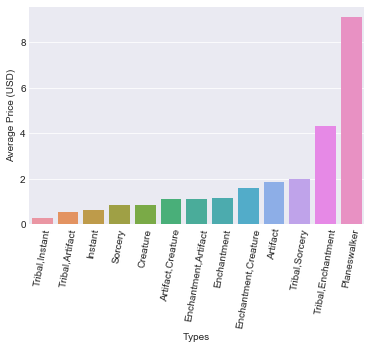

In [79]:
types = uniques.groupby('types')['price'].mean().sort_values()
sns.barplot(x=types.index.values,y=types.values)
plt.xlabel('Types')
plt.xticks(rotation=80)
plt.ylabel('Average Price (USD)')

plt.show()

It looks from this chart that Planeswalkers and Tribal Sorceries and Enchantments are easily the most expensive cards in the format. There are very few planeswalkers and they're very rare and generally very powerful, so it's unsurprising to see a very high average price for them.

There are also very few Tribal cards, so if there are a few high-value Tribal cards, there is a large effect on the average price.

# Looking at total mana costs

Another interesting data set to look at would be the value of cards as they relate to mana cost for each color. Different colors tend to have different strategies. For example, Green tends to try to "Ramp" up to very expensive cards whereas Red tends to rush out a bunch of cheap cards.
Let's see if we can see these tendencies in the card's values:

In [65]:
manacostPrices = pd.DataFrame()
manacostPrices['White'] = uniques.loc[uniques['W']==1].groupby('cmc')['price'].mean()
manacostPrices['Blue'] = uniques.loc[uniques['U']==1].groupby('cmc')['price'].mean()
manacostPrices['Black'] = uniques.loc[uniques['B']==1].groupby('cmc')['price'].mean()
manacostPrices['Red'] = uniques.loc[uniques['R']==1].groupby('cmc')['price'].mean()
manacostPrices['Green'] = uniques.loc[uniques['G']==1].groupby('cmc')['price'].mean()
manacostPrices['Colorless'] = uniques.loc[colorlessFilter].groupby('cmc')['price'].mean()
print(manacostPrices)

        White       Blue     Black       Red      Green  Colorless
cmc                                                               
0    2.760000  30.410000  4.320000  4.250000  18.120000   8.152069
1    0.882362   1.041872  0.697215  0.634492   0.865794   0.877724
2    0.801781   0.902966  0.970592  0.500344   0.931800   1.268341
3    0.713775   0.725656  0.996359  0.597487   0.798170   2.311667
4    0.982261   0.917396  1.001014  0.745045   1.061178   1.000888
5    1.518136   1.448052  1.385503  1.184783   1.457454   2.062088
6    1.130414   1.053486  1.441011  0.701198   1.222620   1.614493
7    1.277042   1.009726  1.916438  1.632615   1.424516   3.713143
8    2.377600   1.946154  2.271071  2.252414   2.706486   6.538182
9    2.343333   1.035385  2.280000  1.449000   1.450000   1.864286
10   4.455000   7.125000  4.187500  4.855000   3.696000  10.726000
15   0.750000        NaN       NaN       NaN   0.750000  42.220000


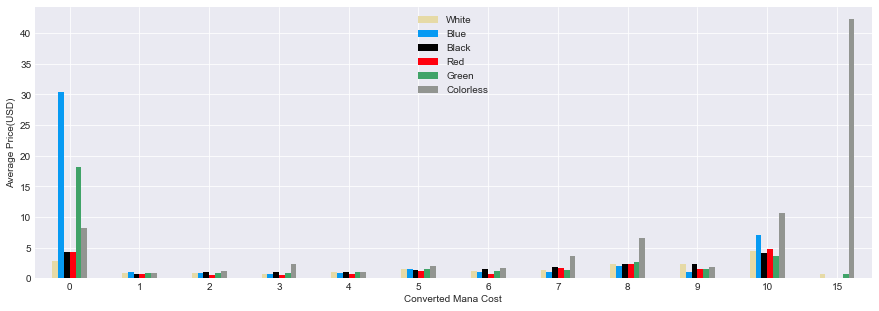

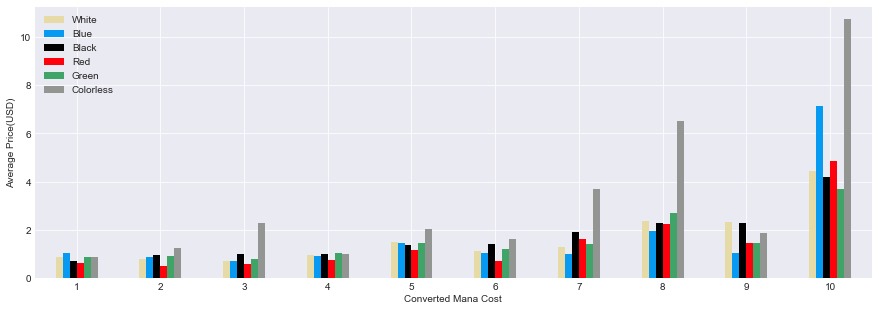

In [66]:
sns.set_style("darkgrid")
sns.set_palette(mtgPalette)

manacostPrices.plot(kind='bar',figsize=(15,5))
plt.xticks(rotation=0)
plt.xlabel('Converted Mana Cost')
plt.ylabel('Average Price(USD)')
plt.show()

#A more focussed plot
manacostPrices.loc[1:10].plot(kind='bar',figsize=(15,5))
plt.xticks(rotation=0)
plt.xlabel('Converted Mana Cost')
plt.ylabel('Average Price(USD)')
plt.show()

There are a few interesting points to note here:
    - Across the board, the value of a card increases with its mana cost, but Blue's increase seems to be less extreme until 10 mana and Black's increase is more steady
    - It's also important to see how valuable 0-cost cards are. Being able to play a card without having to pay any mana upfront is a huge advantage.
    
Let's also look at the variance of the same groups.

In [74]:
percentileManacostPrices = pd.DataFrame()
percentileManacostPrices['White'] = uniques.loc[uniques['W']==1].groupby('cmc')['price'].var()
percentileManacostPrices['Blue'] = uniques.loc[uniques['U']==1].groupby('cmc')['price'].var()
percentileManacostPrices['Black'] = uniques.loc[uniques['B']==1].groupby('cmc')['price'].var()
percentileManacostPrices['Red'] = uniques.loc[uniques['R']==1].groupby('cmc')['price'].var()
percentileManacostPrices['Green'] = uniques.loc[uniques['G']==1].groupby('cmc')['price'].var()
percentileManacostPrices['Colorless'] = uniques.loc[colorlessFilter].groupby('cmc')['price'].var()
print(percentileManacostPrices)

         White       Blue      Black        Red      Green   Colorless
cmc                                                                   
0          NaN        NaN        NaN        NaN        NaN  400.036631
1    16.528205  22.816337   4.214336   2.862744  16.969661   10.819934
2     8.054112  12.230480  16.148943   1.616037  15.757317   14.955126
3     2.943955   3.868973  20.573201   4.183409   5.898175   52.434350
4     5.229633   6.443657   9.715119   4.950900  12.876920    3.538171
5    16.263091  18.622591  16.397488  16.051909  24.019487   14.639788
6     4.119564   4.519549  11.495582   2.115835  10.287501   15.316272
7     6.012578   2.231994  14.859782  14.705810  12.440538  162.085675
8    15.360044   5.649441   4.751343   5.292598  16.490473  114.701696
9     6.576250   0.599610   9.130291   0.781388   2.221556    9.348629
10   17.236967  69.592806  19.232092  14.514967  15.589930  170.021430
15         NaN        NaN        NaN        NaN        NaN         NaN


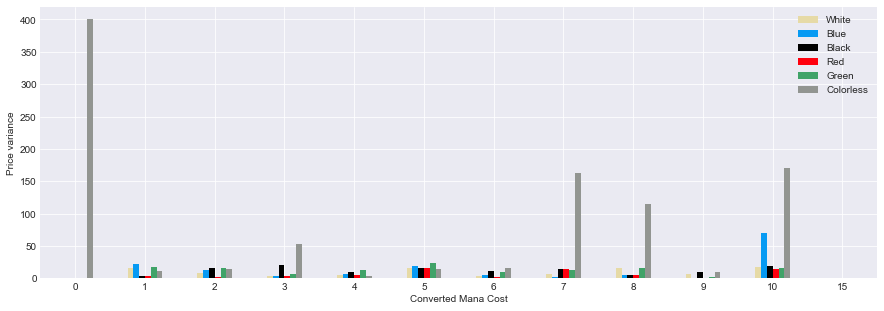

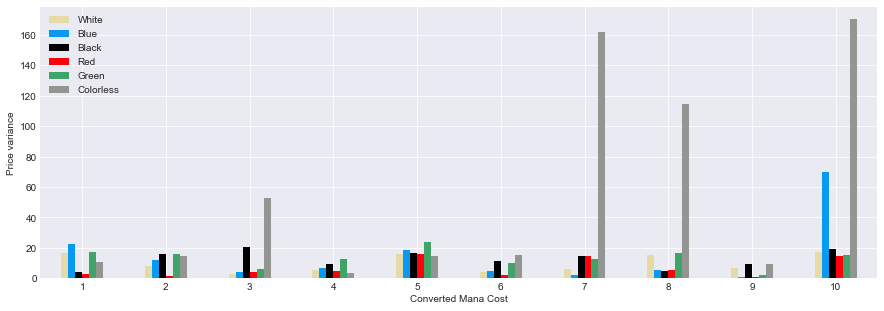

In [78]:
sns.set_style("darkgrid")
sns.set_palette(mtgPalette)

percentileManacostPrices.plot(kind='bar',figsize=(15,5))
plt.xticks(rotation=0)
plt.xlabel('Converted Mana Cost')
plt.ylabel('Price variance')
plt.show()

#A more focussed plot
percentileManacostPrices.loc[1:10].plot(kind='bar',figsize=(15,5))
plt.xticks(rotation=0)
plt.xlabel('Converted Mana Cost')
plt.ylabel('Price variance')
plt.show()

Creatures generally the driving force that win the game in Magic. Using our dataset, we can look for some correlation between the size of a creature (its Power and Toughness) and its value.

In [9]:
bodyPrices = pd.DataFrame()
bodyPrices['White'] = uniques.loc[uniques['W']==1].groupby(['power','toughness'])['price'].mean()
bodyPrices['Blue'] = uniques.loc[uniques['U']==1].groupby(['power','toughness'])['price'].mean()
bodyPrices['Black'] = uniques.loc[uniques['B']==1].groupby(['power','toughness'])['price'].mean()
bodyPrices['Red'] = uniques.loc[uniques['R']==1].groupby(['power','toughness'])['price'].mean()
bodyPrices['Green'] = uniques.loc[uniques['G']==1].groupby(['power','toughness'])['price'].mean()
bodyPrices['Colorless'] = uniques.loc[colorlessFilter].groupby(['power','toughness'])['price'].mean()

In [36]:
transposedBodyPrices = bodyPrices.transpose()
transposedBodyPrices.index.rename('color',inplace=True)
transposedBodyPrices = transposedBodyPrices.reset_index().melt(id_vars='color').replace('*','-1')

transposedBodyPrices['power'] = pd.to_numeric(transposedBodyPrices['power'])
transposedBodyPrices['toughness'] = pd.to_numeric(transposedBodyPrices['toughness'])

In [105]:
def heatmapBodyPrices(color):
    heatmapped = pd.pivot_table(transposedBodyPrices.loc[transposedBodyPrices['color']==color,['power','toughness','value']],index='power',columns='toughness',values='value').fillna(0)
    heatmapped = heatmapped.reindex_axis(sorted(heatmapped.columns), axis=1)
    heatmapped = heatmapped.reindex_axis(sorted(heatmapped.index,reverse=True), axis=0)

    sns.heatmap(heatmapped,cbar_kws={'label': 'Average Price(USD)'}).set_title(color)
    plt.show()

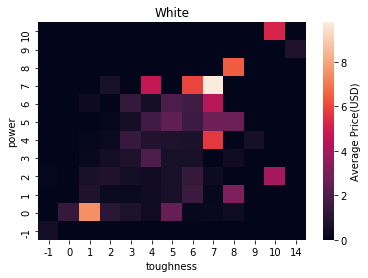

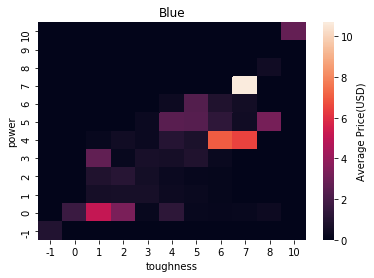

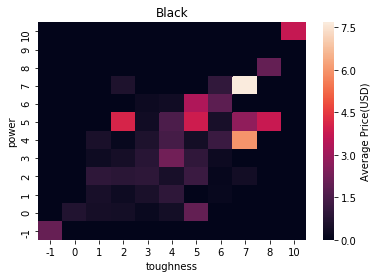

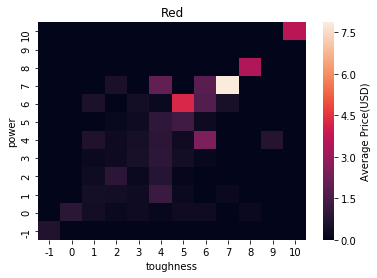

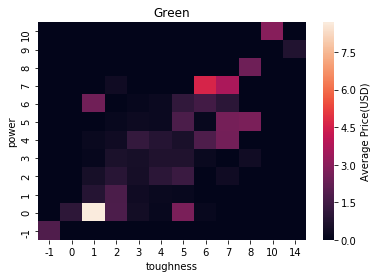

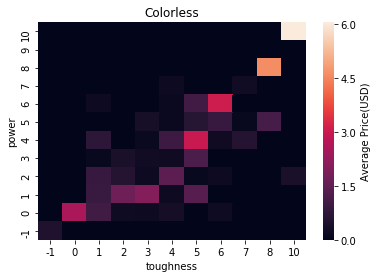

In [107]:
heatmapBodyPrices('White')
heatmapBodyPrices('Blue')
heatmapBodyPrices('Black')
heatmapBodyPrices('Red')
heatmapBodyPrices('Green')
heatmapBodyPrices('Colorless')

Looking at these plots, it looks like for most colors, higher value cards tend to have at least as much toughness as power. There is a bit of an exception with this observation in White and Red.

For the last couple of studies, let's see how the attributes that don't directly affect the game relate to a cards value. Some of these attributes include the set they were printed in and the rarity of the card.

# Sets and Rarities

In [35]:
#Set codes should be an ordered category, this is the order the sets were released
#Using custom Expansion ID for "Modern event deck" = "MEV"
setCategories = CategoricalDtype(['MEV','8ED','MRD','DST','5DN','CHK','BOK','SOK','9ED','RAV','GPT','DIS','CSP','TSB','TSP','PLC','FUT','10E',
                                             'LRW','MOR','SHM','EVE','ALA','CON','ARB','M10','ZEN','WWK','ROE','M11','SOM','MBS','NPH','M12',
                                            'ISD','DKA','AVR','M13','RTR','GTC','DGM','MMA','M14','THS','BNG','JOU','M15','KTK','FRF','DTK','MM2','ORI',
                                             'BFZ','OGW','SOI','EMN','KLD','AER','MM3','AKH','HOU','XLN','RIX'],ordered=True)

In [36]:
setDF = cardsWithPrices.reset_index()

setDF.loc[setDF['setname'] == 'Modern Masters 2015','set'] = 'MM2'
setDF.loc[setDF['setname'] == 'Modern Masters','set'] = 'MMA'
setDF.loc[setDF['setname'] == 'Timeshifted','set'] = 'TSB'
setDF.loc[setDF['setname'] == 'Modern Masters 2017','set'] = 'MM3'
setDF.loc[setDF['setname'] == 'Modern Event Deck','set'] = 'MEV'

setDF['set'] = setDF['set'].astype(setCategories)

setPrices = setDF.groupby('set').agg({'setname':'first','price':'mean'})

In [38]:
print(setPrices)

                    setname     price
set                                  
MEV       Modern Event Deck  3.883333
8ED             8th Edition  0.936860
MRD                Mirrodin  1.190839
DST               Darksteel  1.869689
5DN              Fifth Dawn  2.015515
CHK   Champions of Kamigawa  1.133978
BOK   Betrayers of Kamigawa  1.180435
SOK     Saviors of Kamigawa  0.870248
9ED             9th Edition  0.914025
RAV                 Ravnica  1.239121
GPT               Guildpact  0.826154
DIS              Dissension  1.002956
CSP                Coldsnap  0.947338
TSB             Timeshifted  0.881404
TSP             Time Spiral  1.051547
PLC            Planar Chaos  0.929317
FUT            Future Sight  2.391131
10E            10th Edition  1.219220
LRW                  Lorwyn  1.488864
MOR             Morningtide  1.837808
SHM              Shadowmoor  1.768074
EVE                Eventide  1.430632
ALA         Shards of Alara  1.001005
CON                 Conflux  1.436857
ARB         

C:\Users\Tyler\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


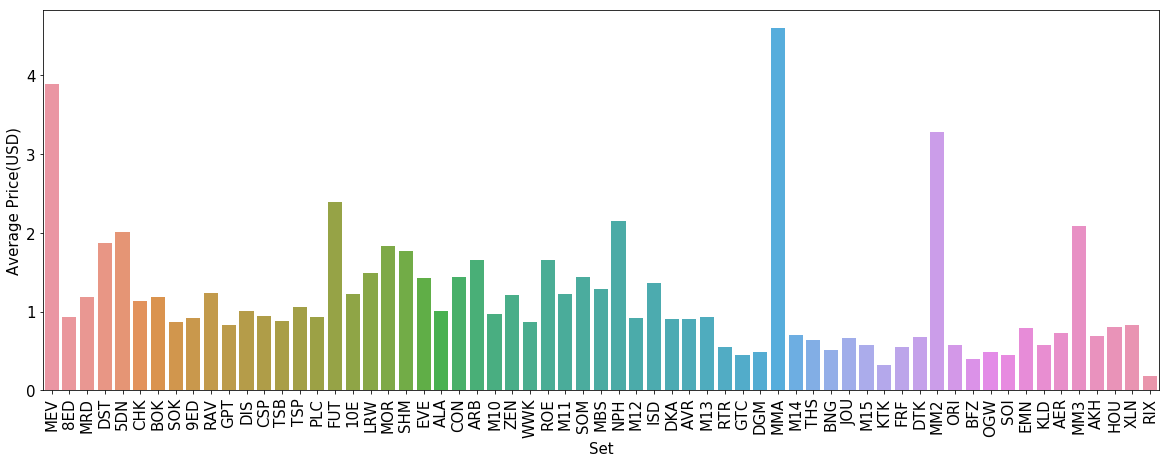

In [37]:
plt.subplots(figsize=(20,7))
plt.xticks(rotation=90,size=15)
plt.yticks(size=15)
sns.barplot(x=setPrices.index,y=setPrices['price'])
plt.xlabel('Set',size=15)
plt.ylabel('Average Price(USD)',size=15)
plt.show()

Looking at the above graph, you can see that cards in the Modern Masters sets (MMA,MM2,MM3) along with the Modern Event Decks (MEV) are a LOT more expensive than the rest of the sets. This is because those sets are compilations of some of the best cards in the Modern Magic format.

Aside from that point, you can also see that generally the older sets are a bit more expensive than the newer sets. It looks like there's a bit of a drop-off in the average price after Magic 2013 (M13) was released. I am wondering whether this has to do with card quality within the sets, or the fact that older sets are no longer printed.

One final thing we can look at is how rarity affects a card's price. Regardless of the impact a card has in the game, clearly the supply of copies of the card available to the public would affect its value, right?

In [34]:
rarityPrices = cardsWithPrices.groupby('rarity')['price'].mean()
rarityPrices.index = pd.Categorical(rarityPrices.index,categories=['Common','Uncommon','Rare','Mythic Rare','Special'],ordered=True)
rarityPrices.sort_index(inplace = True)
print(rarityPrices)

Common         0.189432
Uncommon       0.399223
Rare           2.494607
Mythic Rare    7.439586
Special        0.881404
Name: price, dtype: float64


In [40]:
#Create rarity palette
rarityPalette = sns.color_palette([sns.xkcd_rgb['black'],sns.xkcd_rgb['grey'],sns.xkcd_rgb['yellow'],sns.xkcd_rgb['orange']])

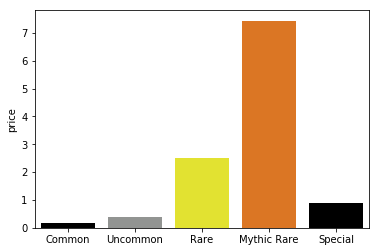

In [41]:
sns.barplot(x=rarityPrices.index,y=rarityPrices,palette=rarityPalette)
plt.show()

As one would expect, the rarer the card, the more expensive it is. The "special" rarity is an exception to this rule because "special" means the card was re-printed as some sort of limited edition event. This means the base card could be of any rarity. Keeping that in mind, Special is still higher value than Uncommon and Common.

Let's see how the plot looks when we take into account the number of cards of each rarity you receive in a standard booster pack. This will kind of normalize the numbers so that the cards' actual rarity is less relevant.

In [42]:
#Each standard pack has 10 Commons, 3 Uncommons, and a 7/8 or 1/8 chance of Rare or Mythic Rare respectively
rarityPrices['Common'] = rarityPrices['Common'] * 10
rarityPrices['Uncommon'] = rarityPrices['Uncommon'] * 3
rarityPrices['Rare'] = rarityPrices['Rare'] * 7/8
rarityPrices['Mythic Rare'] = rarityPrices['Mythic Rare'] * 1/8

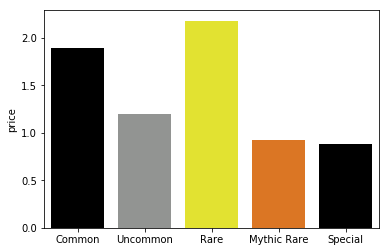

In [45]:
sns.barplot(x=rarityPrices.index,y=rarityPrices,palette=rarityPalette)
plt.show()

It looks like the limited supply of the Mythic Rare cards may be giving them a bit of an advantage over the other rarities! Also, the average value of commons in a pack actually add up to more than the value of the uncommons in a pack!